In [1]:
import json
import os
import argparse
import sys

import torch
from torch import nn, optim
from torch.nn import functional as F
from speaker_encoder import LSTM as model

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(""))))
import commons
import utils
from utils import load_filepaths_and_text, load_wav_to_torch

In [2]:
def audio_processing(audio_path, hps):
    audio, sr = load_wav_to_torch(audio_path)
    audio_norm = audio/ hps.data.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    stft = commons.TacotronSTFT(hps.data.filter_length, hps.data.hop_length, 
                               hps.data.win_length, hps.data.n_mel_channels, 
                               hps.data.sampling_rate, hps.data.mel_fmin,
                               hps.data.mel_fmax)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(torch.tensor(melspec),0)
    melspec = torch.abs(melspec)
    
    frames = hps.data.slice_length
    mel_padded = torch.FloatTensor(1, hps.data.n_mel_channels, frames)
    mel_padded.zero_()
    if melspec.size(1) < frames:
        mel_padded[:, :, :melspec.size(1)] = melspec
    else : 
        mel_padded[:, :, :frames] = melspec[:, :frames]
    return mel_padded/torch.max(mel_padded)

In [3]:
saved_model_path = "/media/caijb/data_drive/GE2E/log/LSTM512/"
config_path = os.path.join(saved_model_path, "config.json")
with open(config_path,"r") as f:
        data = f.read()
config = json.loads(data)
hps = utils.HParams(**config)


#checkpoint_path = utils.latest_checkpoint_path(saved_model_path)
checkpoint_path = os.path.join(saved_model_path, 'EMB_1800.pth')
CAC = model(input_size= hps.data.n_mel_channels, hidden_size= hps.model.l_hidden , embedding_size = hps.model.embedding_size , num_layers=hps.model.num_layers)
CAC, _, _, _ = utils.load_checkpoint(checkpoint_path, CAC)

INFO:root:Loaded checkpoint '/media/caijb/data_drive/GE2E/log/LSTM512/EMB_1800.pth' (iteration 1800)


In [4]:
text_path = "/media/caijb/data_drive/data/Zeroshot/vctk_tester.txt"
with open(text_path, "r") as f:
    data = f.read()
    data = data.split("\n")

    
result = []
for i in data:
    i = i.split("|")
    audio_path, sid = i[0], i[1]
    print(audio_path)
    mel = audio_processing(audio_path, hps)
    mel = torch.transpose(mel, 2,1)
    vector = CAC(mel)
    vector = vector.squeeze()
    temp_vector = vector.tolist()
    temp_vector.append(int(sid))
    result.append(temp_vector)


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_009.wav


/home/caijb/Desktop/zero_shot_glowtts/stft.py:68: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/home/caijb/Desktop/zero_shot_glowtts/commons.py:172: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_010.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_020.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_021.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_030.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_033.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_046.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_049.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_060.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_061.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_072.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_073.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_094.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_103.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_116.wav
/media/caijb/data_dr

In [5]:
import pandas as pd

df = pd.DataFrame(result)
df.to_csv("./result_ge2e_lstm_seen.csv")

In [6]:
import matplotlib.pyplot as plt
df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.462872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,2.463505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [7]:
y = df[[256]]
"""
y =y.replace(125,0)
y =y.replace(124,1)
y =y.replace(113,2)
y =y.replace(115,3)
y =y.replace(114,4)

"""
y =y.replace(2,0)
y =y.replace(3,1)
y =y.replace(4,2)
y =y.replace(5,3)
y =y.replace(6,4)

x = df.drop([256],axis =1)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [9]:
from sklearn.decomposition import PCA
pca =PCA(n_components = 2)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x_pca= pd.DataFrame(x_pca)
x_pca['target']=y

In [10]:
markers = ['o', '^', 's', 'x','p']
name = ['125', '124','113', '115', '114']
#name = ['jing Li','Bart de Leeuw','Tux','HarroTapani Ylilammi','Gilles G.Le Blanc']
sid_list = [125, 124, 113, 115, 114]

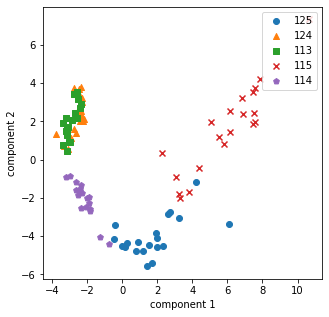

In [11]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_pca[x_pca['target']==i][0]
    y_axis = x_pca[x_pca['target']==i][1]
    
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='upper right')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda= LinearDiscriminantAnalysis(n_components =2)
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)
lda.fit(x_scaled,y)
x_lda = lda.transform(x_scaled)
x_lda = pd.DataFrame(x_lda)
x_lda['target'] = y

/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


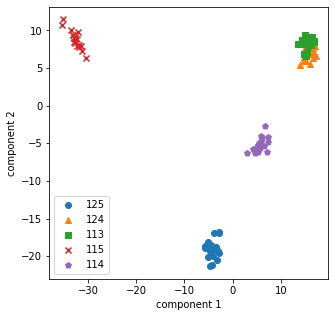

In [17]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_lda[x_lda['target']==i][0]
    y_axis = x_lda[x_lda['target']==i][1]
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='lower left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [14]:
df_new = pd.read_csv("./result_unseen.csv")
df_key =df_new.keys()
x_new =df_new.loc[:,'0':'255']
y_new =df_new['256']
x_new.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.924666,0.089286,-3.938224,2.926810,-0.957647,3.143997,-2.186275,-6.421319,-1.388880,-1.013040,...,0.259372,-5.373376,-2.330171,-2.691827,2.472129,-0.251566,-4.596421,-3.608484,-5.105607,-1.236171
1,0.462356,-2.937201,3.435506,2.948791,3.068054,0.752525,0.890190,-1.973906,2.190769,-1.317015,...,-3.216021,-1.270759,1.161963,2.027223,5.555609,4.819264,-1.449844,-3.340564,-2.505339,1.378487
2,1.122110,-3.094463,3.505273,1.470691,3.724424,0.295554,0.639877,-1.604555,1.236025,-1.170547,...,-1.929254,0.874156,0.186485,0.329011,5.602454,6.386736,-2.379466,-4.770626,-2.294089,-0.396130
3,-0.970038,-3.345170,-4.293344,1.631999,0.379692,1.654221,-2.520056,-1.825457,-0.738866,1.173080,...,-1.164386,-1.624064,0.355218,1.224862,5.657700,2.955873,-9.858859,-3.787415,-5.045282,-1.956984
4,-0.411860,-3.550402,0.988183,1.884595,2.568111,2.947546,-1.694153,-2.952503,2.427681,0.275310,...,-0.823575,-0.708828,-1.760493,2.242008,5.450845,3.319384,-5.453827,-3.915504,-3.725646,-0.864344


In [15]:
x_new_scaled = scaler.fit_transform(x_new)
x_new_lda = pca.transform(x_new_scaled)
x_new_lda = pd.DataFrame(x_new_lda)

y_new=y_new.replace(125,0)
y_new =y_new.replace(124,1)
y_new =y_new.replace(113,2)
y_new =y_new.replace(115,3)
y_new =y_new.replace(114,4)

x_new_lda['target'] = y_new
x_new_lda.head()

,0,1,target
0,0.177813,-0.104248,0
1,1.322435,0.314216,0
2,1.027446,-0.329389,0
3,0.155024,1.923640,0
4,0.762666,0.542507,0


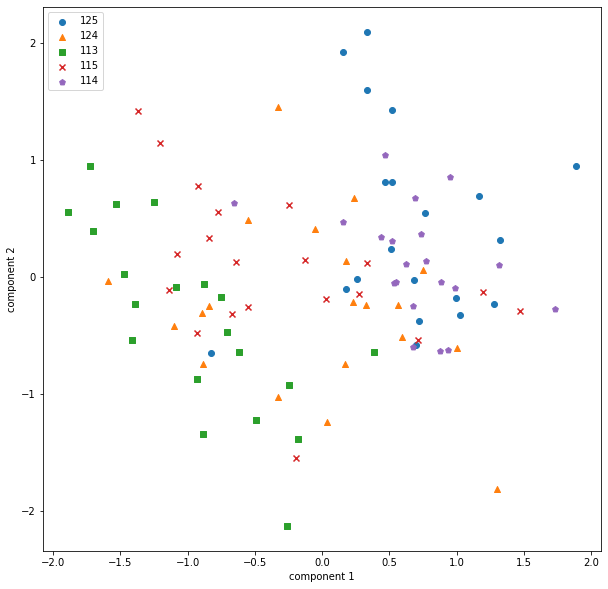

In [16]:
fig = plt.figure(figsize=(10,10))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_new_lda[x_new_lda['target']==i][0]
    y_axis = x_new_lda[x_new_lda['target']==i][1]
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='upper left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()